In [1]:
# Import some packages that we will likely use.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

In [2]:
# Read in the takehome_users data.
users = pd.read_csv('data/takehome_users.csv', encoding='latin-1') # Stack Overflow said to use latin-1 encoding to fix error.
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
# Look at variable details.
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [4]:
# Check dtypes.
users.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [5]:
# Convert dtypes.
users['creation_time'] = users['creation_time'].astype('datetime64')
users.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object

In [6]:
# Check to see which columns, if any, have null values and how many there are.
users_missing = pd.concat([users.isnull().sum(), 100 * users.isnull().mean()], axis=1)
users_missing.columns = ['count', '%']
users_missing.sort_values(by=['count', '%'], ascending=False)

,count,%
invited_by_user_id,5583,46.525
last_session_creation_time,3177,26.475
object_id,0,0.000
creation_time,0,0.000
name,0,0.000
email,0,0.000
creation_source,0,0.000
opted_in_to_mailing_list,0,0.000
enabled_for_marketing_drip,0,0.000
org_id,0,0.000


In [7]:
# Since the minimum value for invited_by_user_id is 3, we can assume that the null values correspond to users that were not invited by anyone.
# Let's fill these null values with 0 to represent not being invited.
users.invited_by_user_id.fillna(0, inplace=True)

# For last_session_creation_time let's just drop the column.
users = users.drop(columns=['last_session_creation_time'])
users.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0


In [8]:
# Read in the takehome_user_engagement data.
user_engage = pd.read_csv('data/takehome_user_engagement.csv')
user_engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [9]:
# Look at variable details.
user_engage.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [10]:
# Check dtypes.
user_engage.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [11]:
# Convert dtypes.
user_engage['time_stamp'] = user_engage['time_stamp'].astype('datetime64')
user_engage.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

In [12]:
# Check to see which columns, if any, have null values and how many there are.
user_engage_missing = pd.concat([user_engage.isnull().sum(), 100 * user_engage.isnull().mean()], axis=1)
user_engage_missing.columns = ['count', '%']
user_engage_missing.sort_values(by=['count', '%'], ascending=False)

,count,%
time_stamp,0,0.0
user_id,0,0.0
visited,0,0.0


In [13]:
# Make our time_stamp column the index in preparation for resampling.
user_engage.index = user_engage.time_stamp
user_engage = user_engage.drop(columns=['time_stamp'])
user_engage.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [14]:
# Group by user_id and resample our time_stamps using 1 week intervals. This only checks for multiple logins from Sun-Sat, so if there are 3 logins from Wed-Tue for example, it wouldn't count it.
user_engage_grouped = user_engage.groupby('user_id').resample('1W').sum()
user_engage_grouped = user_engage_grouped.drop(columns=['user_id'])
user_engage_grouped.head(20)

visited
user_id time_stamp         
1       2014-04-27        1
2       2013-11-17        1
        2013-11-24        0
        2013-12-01        1
        2013-12-08        0
        2013-12-15        1
        2013-12-22        0
        2013-12-29        1
        2014-01-05        1
        2014-01-12        1
        2014-01-19        0
        2014-01-26        0
        2014-02-02        0
        2014-02-09        3
        2014-02-16        2
        2014-02-23        0
        2014-03-02        0
        2014-03-09        1
        2014-03-16        1
        2014-03-23        0

In [15]:
# 'Squish' our grouped dataframe and take the max value of the visited column by user_id.
user_engage_squished = user_engage_grouped.groupby('user_id').max()
user_engage_squished.shape # This is the number of users that have logged in at least once during a week.

(8823, 1)

In [16]:
# Take a look at our new dataframe.
user_engage_squished.head()

,visited
user_id,
1,1
2,3
3,1
4,1
5,1


C:\Users\justi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='visited', ylabel='count'>

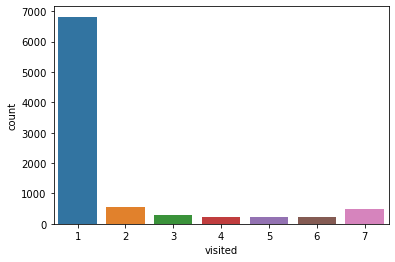

In [17]:
# Create a countplot of users' max number of visits during a 1-week period (Sun-Sat).
sns.countplot(user_engage_squished.visited)

In [18]:
# Subset our dataframe and create a new dataframe containing users that have logged in 3 or more times in a 1-week period (Sun-Sat).
is_adopted = user_engage_squished[user_engage_squished.visited >= 3]
is_adopted.shape # This is the number of users that have logged in at least 3 times during a week.

(1445, 1)

In [19]:
# Print the number of unique IDs that have logged in at least once in a week span.
user_engage.nunique()

user_id    8823
visited       1
dtype: int64

In [20]:
# Check to make sure that our new dataframe has one row for each user (should be equal to above number of rows).
user_engage_squished.shape

(8823, 1)

In [21]:
# Create a new indicator column representing user adoption.
user_engage_final = user_engage_squished.copy()

user_engage_final['adopted'] = [1 if user_engage_final.visited[i] >= 3 else 0 for i in user_engage_final.index]

In [22]:
# Check to see if our new column is present in our dataframe.
user_engage_final = user_engage_final.reset_index()
user_engage_final.head()

,user_id,visited,adopted
0,1,1,0
1,2,3,1
2,3,1,0
3,4,1,0
4,5,1,0


In [23]:
# Drop the visited column along with other columns that aren't useful in the users dataframe for our analysis.
user_engage_final = user_engage_final.drop(columns=['visited'])
users = users.drop(columns=['name', 'email'])
users.rename(columns={'object_id':'user_id'}, inplace=True)

In [24]:
# Merge our adopted column with the users dataframe on user_id.
df = users.merge(user_engage_final, how = 'left', on='user_id')
df.head()

,user_id,creation_time,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,GUEST_INVITE,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,ORG_INVITE,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,ORG_INVITE,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,0,0,193,5240.0,0.0


In [25]:
# Assure that the left join has been done correctly (All 12000 users exist in our dataframe).
df.shape

(12000, 8)

In [27]:
# Check the amount of non-null values for the adopted column in our new dataframe.
user_engage_final.shape

(8823, 2)

In [28]:
# Check dataframe details.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   creation_source             12000 non-null  object        
 3   opted_in_to_mailing_list    12000 non-null  int64         
 4   enabled_for_marketing_drip  12000 non-null  int64         
 5   org_id                      12000 non-null  int64         
 6   invited_by_user_id          12000 non-null  float64       
 7   adopted                     8823 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 843.8+ KB


In [29]:
# Fill null values leftover from left join using 0 (NaN means user never logged in as they were not in the user_engage dataframe).
df.adopted.fillna(0, inplace=True)

In [30]:
# Check dataframe details.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   creation_source             12000 non-null  object        
 3   opted_in_to_mailing_list    12000 non-null  int64         
 4   enabled_for_marketing_drip  12000 non-null  int64         
 5   org_id                      12000 non-null  int64         
 6   invited_by_user_id          12000 non-null  float64       
 7   adopted                     12000 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 843.8+ KB


In [32]:
# Split data into train/test sets.


In [ ]:
# Split data further into numeric and categorical dataframes.

In [ ]:
# Scale numeric features.

In [ ]:
# Create dummy variables for categorical features.

In [ ]:
# Merge numeric and categorical features back together.

In [33]:
# Try a model or two.

In [ ]:
# Look at feature importance and conclude.